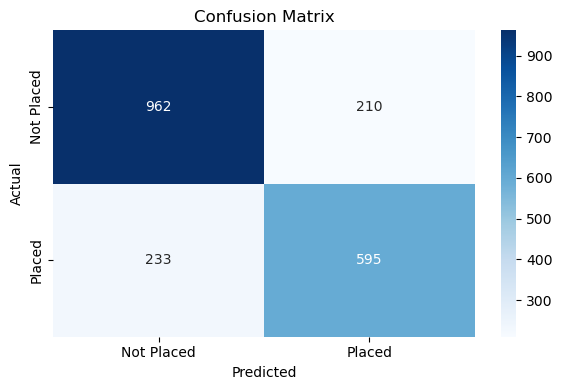

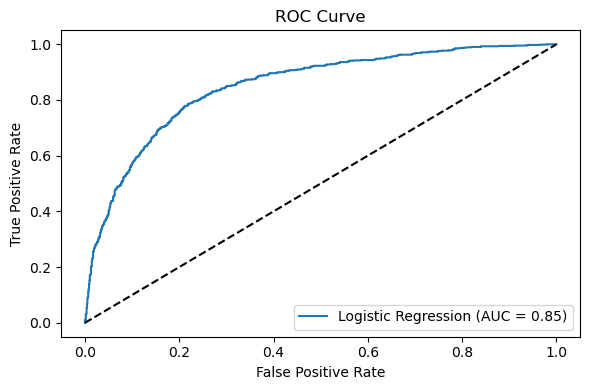

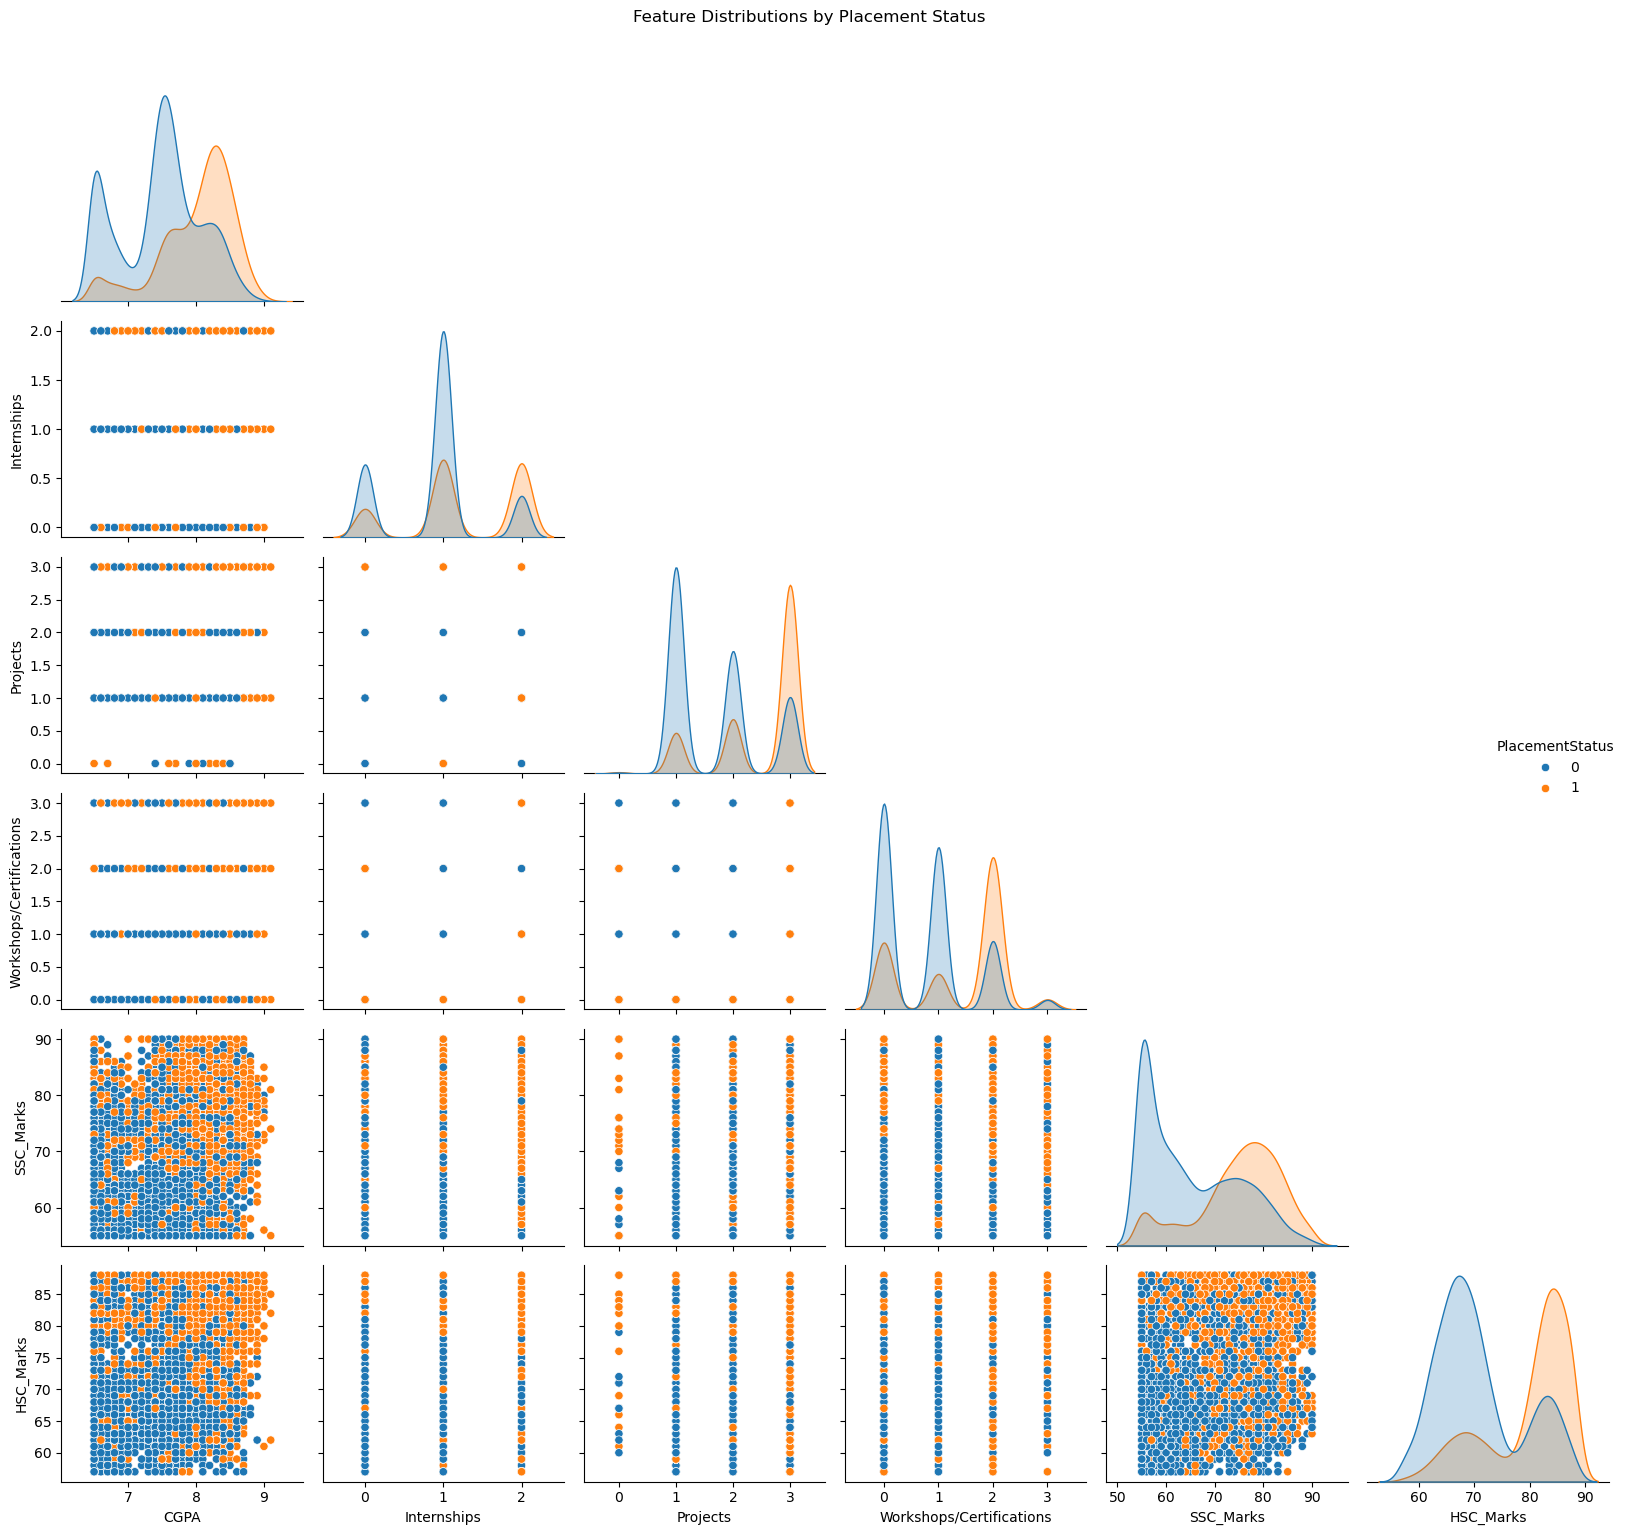

2025-05-22 08:12:06.323 python[82137:1776584] +[IMKClient subclass]: chose IMKClient_Legacy
2025-05-22 08:12:06.323 python[82137:1776584] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter import messagebox, ttk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import webbrowser
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


data = pd.read_csv('updated_placement_data.csv')
data['PlacementStatus'] = data['PlacementStatus'].map({'Placed': 1, 'NotPlaced': 0})





feature_weights = {
    'CGPA': 3.0,
    'Internships': 5.5,
    'Projects': 0.5,
    'Workshops/Certifications': 1.5,
    'SSC_Marks': 0.004,
    'HSC_Marks': 0.008
}
fields = list(feature_weights.keys())


X = data[fields]
y = data['PlacementStatus']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_weighted = X_train.copy()
X_test_weighted = X_test.copy()
for column, weight in feature_weights.items():
    X_train_weighted[column] *= weight
    X_test_weighted[column] *= weight


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_weighted)
X_test_scaled = scaler.transform(X_test_weighted)


poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


log_model = LogisticRegression(solver='liblinear')
log_model.fit(X_train_poly, y_train)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_poly, y_train)


y_pred_rf = rf_model.predict(X_test_poly)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test_poly)[:, 1])


y_pred = log_model.predict(X_test_poly)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_poly)[:, 1])


if accuracy_rf > accuracy:
    model = rf_model
    best_model_name = "Random Forest"
    accuracy = accuracy_rf
    f1 = f1_rf
    precision = precision_rf
    recall = recall_rf
    roc_auc = roc_auc_rf
else:
    model = log_model
    best_model_name = "Logistic Regression"

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Placed', 'Placed'], yticklabels=['Not Placed', 'Placed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_poly)[:, 1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



sns.pairplot(data[fields + ['PlacementStatus']], hue='PlacementStatus', corner=True)
plt.suptitle("Feature Distributions by Placement Status", y=1.02)
plt.tight_layout()
plt.show()





root = Tk()
root.title("Placement Predictor & Career Roadmap")
root.geometry("800x950")

input_frame = Frame(root)
input_frame.pack(pady=10)

entries = {}
fields = ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications', 'SSC_Marks', 'HSC_Marks']
for i, field in enumerate(fields):
    Label(input_frame, text=f"{field}:").grid(row=i, column=0, sticky=W)
    entry = Entry(input_frame)
    entry.grid(row=i, column=1)
    entries[field] = entry

result_label = Label(input_frame, text="Predicted Placement Percentage: N/A", font=('Helvetica', 12, 'bold'))
result_label.grid(row=7, column=0, columnspan=2, pady=10)
metrics_label = Label(input_frame, text="", font=('Helvetica', 10))
metrics_label.grid(row=8, column=0, columnspan=2, pady=5)

def on_predict():
    try:
        inputs = [float(entries[field].get()) for field in fields]
        for i, key in enumerate(feature_weights):
            inputs[i] *= feature_weights[key]
        inputs = np.array(inputs).reshape(1, -1)
        scaled_input = scaler.transform(inputs)
        poly_input = poly.transform(scaled_input)
        placement_probability = model.predict_proba(poly_input)[0][1] * 100
        result_label.config(text=f"Predicted Placement Percentage: {placement_probability:.2f}% ({best_model_name})")

        roadmap_button.config(state=NORMAL)
        metrics_text = f"Accuracy: {accuracy*100:.2f}% | F1 Score: {f1:.2f}\nPrecision: {precision:.2f} | Recall: {recall:.2f}"
        metrics_label.config(text=metrics_text)
    except Exception as e:
        messagebox.showerror("Input Error", f"Enter valid numeric values.\nDetails: {str(e)}")

Button(input_frame, text="Predict Placement", command=on_predict).grid(row=6, column=0, columnspan=2, pady=10)


roadmap_frame = Frame(root)
roadmap_frame.pack(pady=20)
Label(roadmap_frame, text="Branch:").grid(row=0, column=0, sticky=W)
branch_combobox = ttk.Combobox(roadmap_frame, values=[], width=30)
branch_combobox.grid(row=0, column=1)
Label(roadmap_frame, text="Technical Interest:").grid(row=1, column=0, sticky=W)
interest_combobox = ttk.Combobox(roadmap_frame, width=30)
interest_combobox.grid(row=1, column=1)
Label(roadmap_frame, text="Skill Level (1-10):").grid(row=2, column=0, sticky=W)
skill_level_combobox = ttk.Combobox(roadmap_frame, values=list(range(1, 11)), width=30)
skill_level_combobox.grid(row=2, column=1)
roadmap_button = Button(roadmap_frame, text="Get Learning Resources", command=lambda: show_roadmap(), state=DISABLED)
roadmap_button.grid(row=3, column=0, columnspan=2, pady=10)
link_frame_label = Label(root, text="Recommended Learning Resources:", font=('Helvetica', 12, 'bold'))
link_frame_label.pack()
link_frame = Frame(root)
link_frame.pack(padx=10, pady=10, fill=BOTH, expand=True)

branch_fields = {
    'Computer Science': ['Web Development', 'Machine Learning', 'Cybersecurity', 'App Development'],
    'Electronics': ['Embedded Systems', 'IoT', 'VLSI Design', 'Signal Processing'],
    'Mechanical': ['CAD', 'Thermodynamics', 'Robotics', 'Manufacturing Processes'],
    'Civil': ['Structural Design', 'Construction Management', 'Surveying', 'GIS'],
    'Electrical': ['Power Systems', 'Control Systems', 'Electric Vehicles', 'Smart Grids'],
    'Chemical': ['Process Engineering', 'Fluid Mechanics', 'Chemical Reactions']
}


roadmap_links = {
    "Artificial Intelligence": {
        "elementary": [
            "https://www.coursera.org/learn/ai-for-everyone",
            "https://www.udacity.com/course/ai-for-beginners--ud410"
        ],
        "intermediate": [
            "https://www.coursera.org/specializations/deep-learning",
            "https://www.edx.org/professional-certificate/harvardx-artificial-intelligence"
        ],
        "advanced": [
            "https://openai.com/research",
            "https://ai.stanford.edu/courses/"
        ]
    },
    "Machine Learning": {
        "elementary": [
            "https://www.coursera.org/learn/machine-learning",
            "https://www.kaggle.com/learn/intro-to-machine-learning"
        ],
        "intermediate": [
            "https://www.coursera.org/specializations/machine-learning",
            "https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t"
        ],
        "advanced": [
            "https://stanford.edu/~shervine/teaching/cs-229",
            "https://www.deeplearning.ai/ai-notes/"
        ]
    },
    "Cloud Computing": {
        "elementary": [
            "https://www.coursera.org/learn/cloud-computing-basics",
            "https://aws.amazon.com/training/course-descriptions/cloud-practitioner-essentials/"
        ],
        "intermediate": [
            "https://www.coursera.org/professional-certificates/aws-cloud-solutions-architect",
            "https://cloud.google.com/certification/cloud-architect"
        ],
        "advanced": [
            "https://www.edx.org/professional-certificate/linuxfoundationx-cloud-computing",
            "https://www.cloudarchitecture.institute/"
        ]
    },
    "Cybersecurity": {
        "elementary": [
            "https://www.coursera.org/learn/cybersecurity-fundamentals",
            "https://www.udacity.com/course/intro-to-cybersecurity--ud1337"
        ],
        "intermediate": [
            "https://www.sans.org/cyber-security-training/",
            "https://www.coursera.org/professional-certificates/google-cybersecurity"
        ],
        "advanced": [
            "https://www.offensive-security.com/",
            "https://www.blackhat.com/training/"
        ]
    },
    "5G/6G Network Technologies": {
        "elementary": [
            "https://www.coursera.org/learn/5g-fundamentals",
            "https://www.edx.org/course/5g-fundamentals"
        ],
        "intermediate": [
            "https://www.ieee.org/conferences/networking/5g-summit.html",
            "https://www.3gpp.org/technologies/5g-system-overview"
        ],
        "advanced": [
            "https://www.5gamericas.org/",
            "https://5gobservatory.eu/"
        ]
    },
    "Embedded Systems": {
        "elementary": [
            "https://www.coursera.org/learn/introduction-embedded-systems",
            "https://www.udemy.com/topic/embedded-systems/"
        ],
        "intermediate": [
            "https://www.edx.org/professional-certificate/embedded-systems-design",
            "https://www.udacity.com/course/embedded-systems-nanodegree--nd156"
        ],
        "advanced": [
            "https://ocw.mit.edu/courses/6-088-introduction-to-embedded-systems-fall-2005/",
            "https://www.embedded.com/"
        ]
    },
    "Robotics": {
        "elementary": [
            "https://www.coursera.org/learn/robotics-fundamentals",
            "https://www.edx.org/learn/robotics"
        ],
        "intermediate": [
            "https://www.udacity.com/course/robotics-software-engineer--nd209",
            "https://www.coursera.org/specializations/robotics"
        ],
        "advanced": [
            "https://www.ri.cmu.edu/education/",
            "https://www.robotics.org/"
        ]
    },
    "Smart Grid Technologies": {
        "elementary": [
            "https://www.coursera.org/learn/smart-grid-fundamentals",
            "https://www.edx.org/course/smart-grid-fundamentals"
        ],
        "intermediate": [
            "https://www.ieee.org/conferences/networking/smart-grid-summit.html",
            "https://www.coursera.org/specializations/smart-grid-technology"
        ],
        "advanced": [
            "https://smartgrid.ieee.org/",
            "https://www.energy.gov/oe/activities/technology-development/grid-modernization-and-smart-grid"
        ]
    },
    "Automotive Engineering": {
        "elementary": [
            "https://www.coursera.org/learn/automotive-engineering-basics",
            "https://www.udemy.com/topic/automotive-engineering/"
        ],
        "intermediate": [
            "https://www.edx.org/professional-certificate/automotive-engineering",
            "https://www.udacity.com/course/automotive-engineer-nanodegree--nd013"
        ],
        "advanced": [
            "https://www.sae.org/learn",
            "https://www.automotive-engineering.org/"
        ]
    },
    "Sustainable Infrastructure": {
        "elementary": [
            "https://www.coursera.org/learn/sustainable-infrastructure",
            "https://www.edx.org/course/sustainable-infrastructure"
        ],
        "intermediate": [
            "https://www.coursera.org/specializations/sustainable-infrastructure",
            "https://www.worldgreenbuilding.org/education"
        ],
        "advanced": [
            "https://www.sustainableinfrastructure.org/",
            "https://www.istructe.org/sustainability/"
        ]
    },
    "Biotechnology": {
        "elementary": [
            "https://www.coursera.org/learn/biotech-fundamentals",
            "https://www.edx.org/learn/biotechnology"
        ],
        "intermediate": [
            "https://www.coursera.org/specializations/biotechnology",
            "https://www.udacity.com/course/biotechnology-nanodegree"
        ],
        "advanced": [
            "https://www.nature.com/subjects/biotechnology",
            "https://www.biosociety.org/"
        ]
    }
}

def open_link(link):
    webbrowser.open(link)

def update_technical_interests(event):
    branch = branch_combobox.get()
    technical_areas = branch_fields.get(branch, [])
    interest_combobox.config(values=technical_areas)
    interest_combobox.set('')
    roadmap_button.config(state=DISABLED)

def on_interest_select(event):
    if branch_combobox.get() and interest_combobox.get() and skill_level_combobox.get():
        roadmap_button.config(state=NORMAL)
    else:
        roadmap_button.config(state=DISABLED)

def show_roadmap():
    branch = branch_combobox.get()
    interest = interest_combobox.get()
    skill_level = int(skill_level_combobox.get())
    if interest not in branch_fields.get(branch, []):
        messagebox.showerror("Error", f"{interest} is not a valid field for {branch}.")
        return
    level = 'elementary' if skill_level <= 4 else 'intermediate' if skill_level <= 7 else 'advanced'
    links = roadmap_links.get(interest, {}).get(level, [])
    for widget in link_frame.winfo_children():
        widget.destroy()
    if links:
        for link in links:
            btn = Button(link_frame, text=link, command=lambda l=link: open_link(l), wraplength=550, justify=LEFT)
            btn.pack(anchor='w', padx=5, pady=2)
    else:
        messagebox.showinfo("Info", "No resources available for this selection.")

branch_combobox.bind("<<ComboboxSelected>>", update_technical_interests)
interest_combobox.bind("<<ComboboxSelected>>", on_interest_select)
skill_level_combobox.bind("<<ComboboxSelected>>", on_interest_select)
branch_combobox.config(values=list(branch_fields.keys()))
root.mainloop()